<a href="https://colab.research.google.com/github/mangleshpatidar/DO101-apps/blob/master/MyDecisionTreeClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn import tree


In [42]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


In [43]:
#Use CART Decision Tree
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=15, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)


# create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
# calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
# parent entropy
        parent_entropy = self._entropy(y)

# create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

# calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

# Entropy Formula
    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [44]:
df=pd.read_csv('Q1Data.csv')
df=df.iloc[:,:6].join(df.iloc[:,22])
df

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,Genus
0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,Adenomera
1,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,Adenomera
2,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,Adenomera
3,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,Adenomera
4,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,Adenomera
...,...,...,...,...,...,...,...
7190,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,Scinax
7191,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,Scinax
7192,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,Scinax
7193,-0.519497,-0.307553,-0.004921,0.072865,0.377131,0.086866,Scinax


In [45]:
encoder= LabelEncoder()

df['Genus']=encoder.fit_transform(df['Genus'])
print(df)

      MFCCs_ 1  MFCCs_ 2  MFCCs_ 3  MFCCs_ 4  MFCCs_ 5  MFCCs_ 6  Genus
0     0.152936 -0.105586  0.200722  0.317201  0.260764  0.100945      0
1     0.171534 -0.098975  0.268425  0.338672  0.268353  0.060835      0
2     0.152317 -0.082973  0.287128  0.276014  0.189867  0.008714      0
3     0.224392  0.118985  0.329432  0.372088  0.361005  0.015501      0
4     0.087817 -0.068345  0.306967  0.330923  0.249144  0.006884      0
...        ...       ...       ...       ...       ...       ...    ...
7190 -0.554504 -0.337717  0.035533  0.034511  0.443451  0.093889      7
7191 -0.517273 -0.370574  0.030673  0.068097  0.402890  0.096628      7
7192 -0.582557 -0.343237  0.029468  0.064179  0.385596  0.114905      7
7193 -0.519497 -0.307553 -0.004921  0.072865  0.377131  0.086866      7
7194 -0.508833 -0.324106  0.062068  0.078211  0.397188  0.094596      7

[7195 rows x 7 columns]


In [46]:
scaler=StandardScaler()
X=df.iloc[:,:6].values
X=scaler.fit_transform(X)
X

array([[-0.78050205, -1.58176852, -1.52994436,  1.16866552,  1.35232733,
         0.59711873],
       [-0.69543929, -1.55667956, -1.10763389,  1.30062214,  1.41535915,
         0.36309656],
       [-0.78333419, -1.49595272, -0.99097251,  0.91553598,  0.76349797,
         0.05899196],
       ...,
       [-4.14447709, -2.48364119, -2.59816968, -0.3863707 ,  2.3891063 ,
         0.67857314],
       [-3.85605697, -2.34822135, -2.81267886, -0.33298818,  2.31880165,
         0.51497842],
       [-3.8072824 , -2.41103812, -2.39482322, -0.30013385,  2.48538973,
         0.56007913]])

In [47]:
y=df.iloc[:,-1].values

y

array([0, 0, 0, ..., 7, 7, 7])

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.8, random_state=0)

In [50]:
# Initialize lists to store accuracy values
train_accuracy = []
test_accuracy = []
max_depth_values = list(range(1, 16))

for depth in max_depth_values:
    model = DecisionTree(max_depth=depth)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))


In [51]:
print(max_depth_values)
print(train_accuracy)
print(test_accuracy)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0.6761640027797081, 0.7727588603196665, 0.8220986796386379, 0.862404447533009, 0.8943710910354413, 0.9312022237665045, 0.95135510771369, 0.9791521890201529, 0.9867963863794301, 0.9944405837387075, 0.9993050729673384, 0.9993050729673384, 1.0, 1.0, 1.0]
[0.6794649061848506, 0.7607713690062543, 0.8170604586518415, 0.8372133425990271, 0.8516330785267547, 0.8646629603891591, 0.8763029881862404, 0.8801250868658791, 0.8802988186240445, 0.8724808895066019, 0.871264767199444, 0.8757817929117443, 0.8724808895066019, 0.8719596942321056, 0.8716122307157749]


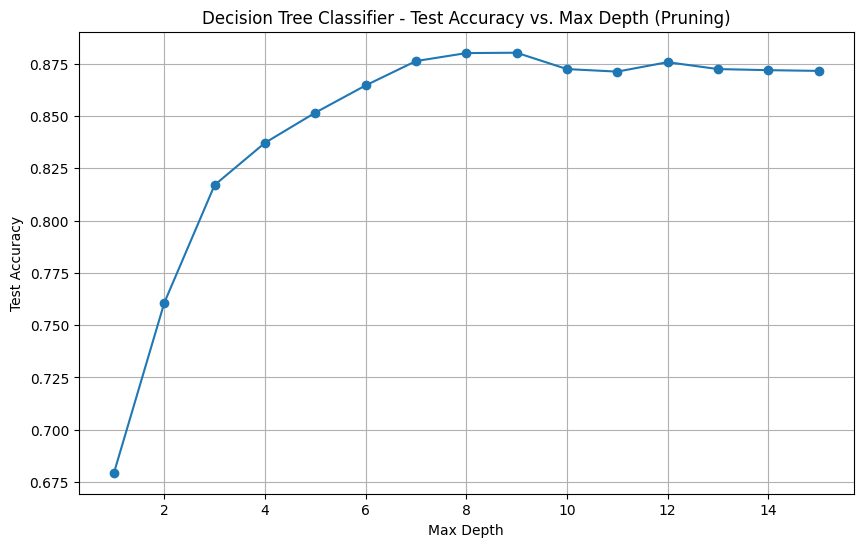

In [52]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, test_accuracy, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Test Accuracy')
plt.title('Decision Tree Classifier - Test Accuracy vs. Max Depth (Pruning)')
plt.grid(True)
plt.show()
